#  Neural-Network-based Equalization in Channels with Intersymbol-Interference

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* Transmission over an ISI channel and time-domain equalization
* Training a nonlinear equalizer using the minimum mean squared error (MMSE) criterion and using it with a neural-network based demapper
* Jointly training a nonlinear equalizer and a neural-network-based demapper
* Jointly training a nonlinear equalizer and a standard demapper assuming a Gaussian distribution

This notebook is inspired by [1].

[1] F. Diedolo, G. Böcherer, M. Schädler, S. Calabro, "Nonlinear Equalization for Optical Communications Based on Entropy-Regularized Mean Square Error," preprint https://arxiv.org/pdf/2206.01004.pdf

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


We consider transmission over a linear channel characterized by its impulse response $\boldsymbol{h} = \begin{pmatrix} h_0 & h_1 & \cdots & h_{L-1}\end{pmatrix}$ and subject to complex additive white Gaussian noise (AWGN). Let $t_i$ be the sequence of transmit symbols, with $t_i \in\mathcal{M}$ ($\mathcal{M}$ being the constellation), the channel output is given by
$$
r_i = \sum_{j=0}^{L-1}h_j t_{i-j} + n_i
$$
with $n_i \sim\mathcal{CN}(0,\sigma_n^2)$.

In [2]:
constellations = {'16-QAM': np.array([-3,-3,-3,-3,-1,-1,-1,-1,1,1,1,1,3,3,3,3]) + 1j*np.array([-3,-1,1,3,-3,-1,1,3,-3,-1,1,3,-3,-1,1,3]), \
                  '16-APSK': np.array([1,-1,0,0,1.4,1.4,-1.4,-1.4,3,-3,0,0,5,-5,0,0]) + 1j*np.array([0,0,1,-1,1.4,-1.4,1.4,-1.4,0,0,4,-4,0,0,6,-6])}

# channel impulse response, Proakis A channel
h_ch = np.array( [0.04, -0.05, 0.07, -0.21, -0.5, 0.72, 0.36, 0.0, 0.21, 0.03, 0.07] )

# choose constellation
con = '16-QAM'

# normalize channel impulse response
h_ch = h_ch / np.sqrt(np.sum(np.square(h_ch)))


# permute constellations so that it is visually more appealing with the chosen colormap
# additionally normalize constellations so that transmit symbol has unit energy
for cname in constellations.keys():
    constellations[cname] = constellations[cname][np.random.permutation(len(constellations[cname]))]
    constellations[cname] /= np.sqrt(np.mean(np.square(np.abs(constellations[cname]))))

    
# simulate the channel    
def simulate_channel(x, h, EsN0_dB):  
    EsN0_lin = 10.0 ** (EsN0_dB / 10.0)
    sigma_n = np.sqrt( 0.5 / EsN0_lin )
    
    xt = np.convolve(x, h)
    
    return xt + sigma_n * ( np.random.randn(len(xt)) + 1j*np.random.randn(len(xt)) )

Function preparing a mini-batch. Each element of the mini-batch is a sequence of length $S$ and corresponds to one transmit symbol. We return both the channel input sequence, the mini-batch sequence and the transmit symbol index (as well as the corresponding one-hot representation). As we cannot easily handle complex numbers, we concatenate real and imaginary parts.

In [3]:
def prepare_minibatch(constellation, h, EsN0_dB, batch_size, seq_length):
    # generate random symbols
    t = np.random.randint(len(constellation), size=seq_length + (batch_size - 1) + (len(h)-1) )
    x = constellation[t]
    
    # simulate the channel with impulse response h and EsN0
    y = simulate_channel(x, h, EsN0_dB)
    
    # throw away first and last samples (ringing artifacts)
    y = y[(len(h)-1):-(len(h)-1)]
    
    # convert to PyTorch data and extract both real and imaginary part
    y_torch_re = torch.from_numpy(np.real(y)).float().to(device)
    y_torch_im = torch.from_numpy(np.imag(y)).float().to(device)

    # Use the unfold command to generate the sliding window sequence
    y_torch_re = y_torch_re.unfold(dimension=0, size=seq_length, step=1 )
    y_torch_im = y_torch_im.unfold(dimension=0, size=seq_length, step=1 )
    
    # stack real and imaginary part
    y_torch = torch.hstack( (y_torch_re, y_torch_im) )
    
    # generate reference sequence    
    half_len = seq_length // 2
    
    # cut midpoint symbols in sequence (throw away first and last symbols)
    t_cut = t[(len(h)-1 + half_len) + np.arange(batch_size)]
    x_cut = x[(len(h)-1 + half_len) + np.arange(batch_size)]
    
    # convert modulation symbols into PyTorch data structure
    x_torch_re = torch.from_numpy(np.real(x_cut)).float().to(device)
    x_torch_im = torch.from_numpy(np.imag(x_cut)).float().to(device)
    
    # stack real and imaginary parts        
    x_torch = torch.transpose(torch.vstack( (x_torch_re, x_torch_im) ), 0, 1)
       
    # convert symbols to one-hot vector
    t_torch = torch.from_numpy(t_cut).to(device)
    
    t_onehot_torch = torch.zeros(batch_size, len(constellation), device=device)
    t_onehot_torch[range(t_onehot_torch.shape[0]), t_torch.long()]=1
    
    return t_torch, t_onehot_torch, x_torch, y_torch

Test the mini-batch generation

In [162]:
t, toh, x, y = prepare_minibatch(constellations['16-QAM'], h_ch, 200, batch_size=3, seq_length=5)
print(x)
print(y)

tensor([[-0.3162,  0.9487],
        [-0.3162,  0.3162],
        [ 0.3162,  0.3162]], device='cuda:0')
tensor([[ 0.4235,  0.0569,  0.3856, -0.8534,  0.2718,  0.1517, -0.4172, -0.3540,
          1.0367, -0.3477],
        [ 0.0569,  0.3856, -0.8534,  0.2718, -0.2908, -0.4172, -0.3540,  1.0367,
         -0.3477, -1.3654],
        [ 0.3856, -0.8534,  0.2718, -0.2908,  0.6132, -0.3540,  1.0367, -0.3477,
         -1.3654,  0.2149]], device='cuda:0')


Implement a nonlinear equalizer using a neural network. The input is a vector of sequence length (real and imaginary part), which is then processed by two hidden layers (fully connected linear layer with ELU activation function) and finally a linear output layer with 2 outputs (real part and imaginary part)

In [6]:
class Equalizer_Network(nn.Module):
    def __init__(self, input_neurons, hidden_neurons_1, hidden_neurons_2):
        super(Equalizer_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(input_neurons, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Output layer
        self.fc3 = nn.Linear(hidden_neurons_2, 2)
        
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer
        out = self.fc3(out)
        
        return out

Train the neural network using Adam and a varying batch size.

In [163]:
EsN0_dB = 15

seq_length = len(h_ch)*3
model_eq = Equalizer_Network(seq_length*2, 50, 20)
model_eq.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.MSELoss()

# Adam Optimizer
optimizer = optim.Adam(model_eq.parameters())  

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        _, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        outputs = model_eq(y)
        
        # compute loss
        loss = loss_fn(outputs, x)
        
         # compute gradients
        loss.backward()
        
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.02601309865713119506836
Epoch 10: Loss 0.02314617298543453216553
Epoch 20: Loss 0.01740925759077072143555
Epoch 30: Loss 0.01265004649758338928223
Epoch 40: Loss 0.01344926189631223678589
Epoch 50: Loss 0.01262078993022441864014
Epoch 60: Loss 0.01295540761202573776245
Epoch 70: Loss 0.01398865692317485809326
Epoch 80: Loss 0.01295723021030426025391
Epoch 90: Loss 0.01237800903618335723877


Plot the constellation after the equalizer

Text(0.5, 1.0, 'Equalized constellation')

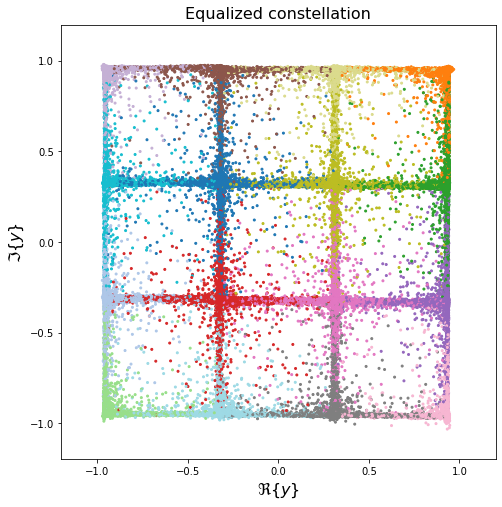

In [170]:
# Evaluate
model_eq.eval()

t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, 100000, seq_length)

f_eq = model_eq(y).cpu().detach().numpy()
r_ch = y.cpu().detach().numpy()
t_sym = t.cpu().detach().numpy()

plt.figure(figsize=(8,8))
plt.scatter(f_eq[:,0], f_eq[:,1], c=t_sym, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=16)
plt.ylabel(r'$\Im\{y\}$',fontsize=16)
plt.xlim((-1.2, 1.2))
plt.ylim((-1.2, 1.2))
plt.title('Equalized constellation',fontsize=16)


Implement a neural network-based demapper. The neural network-based demapper approximates posterior probabilities $P(t_i | y_i)$, where $y_i$ is the equalizer output, using a neural network, which outputs the approximates $Q(t_i|y_i)$. We do not need to implement the soft function, as it is already part of the network.

In [165]:
class Demapper_Network(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2, output_neurons):
        super(Demapper_Network, self).__init__()
        # Linear function, 2 input neurons (real and imaginary part)        
        self.fc1 = nn.Linear(2, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
       
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Output layer
        self.fc3 = nn.Linear(hidden_neurons_2, output_neurons)
        
        

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, third layer, do not use softmax, as it is already part of the loss function
        out = self.fc3(out)
        
        return out

In [166]:
# Train demapper
model_demap = Demapper_Network(20, 30, len(constellations[con]))
model_demap.to(device)

# Cross Entropy loss accepting logits at input
loss_fn = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer_demap = optim.Adam(model_demap.parameters())  

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_eq(y)
        
        # Apply demapper
        outputs = model_demap(yeq)
        
        # compute loss        
        loss = loss_fn(outputs.squeeze(), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_demap.step()
                              
        # reset gradients
        optimizer_demap.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.31017130613327026367188
Epoch 10: Loss 0.21973705291748046875000
Epoch 20: Loss 0.24425670504570007324219
Epoch 30: Loss 0.28649765253067016601562
Epoch 40: Loss 0.22870980203151702880859
Epoch 50: Loss 0.25364512205123901367188
Epoch 60: Loss 0.24264660477638244628906
Epoch 70: Loss 0.21528418362140655517578
Epoch 80: Loss 0.22351555526256561279297
Epoch 90: Loss 0.22553525865077972412109


Evaluate the performance over a range of $E_{\mathrm{s}}/N_0$. Calcualte both the symbol error rate and the achievable information rate, which is given by 
$$
H(\mathsf{t}) + \mathbb{E}_{\mathsf{y},\mathsf{t}}\{\log_2(Q(\mathsf{t}|\mathsf{y}))\}
$$
and we approximate the expectation using the law of large numbers and a batch. We know that $H(\mathsf{t}) = \log_2|\mathcal{M}|$.

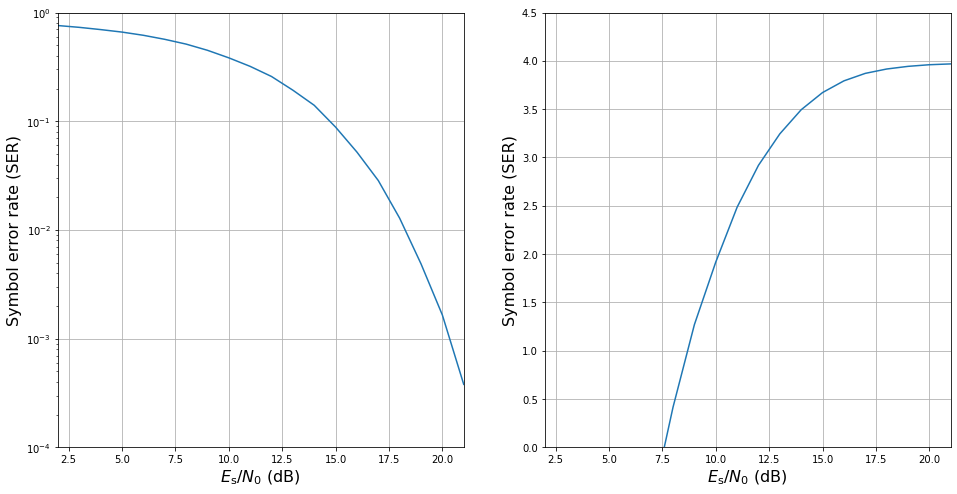

In [167]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

# Evaluate
model_eq.eval()
model_demap.eval()

softmax = nn.Softmax(dim=1)

# compute SER and mutual information over a range of EsN0

esno_range_eval = np.arange(2,22)
SER_separate = np.zeros(len(esno_range_eval))
MI_separate = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = softmax(model_demap( model_eq(y) ))
    
    SER_separate[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_separate[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(0.00000000001 + tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, mySER)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')

plt.subplot(122)
plt.plot(esno_range, MI_separate)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')



---
### Comparison: Joint training of equalizer and demapper

Now, we do not train the equalizer and demapper separately, but we train them jointly. Note that minimizing the cross-entropy loss is equivalent to maximizing the esimate of the achievable information rate.

In [168]:
# Joint training
model_jeq = Equalizer_Network(seq_length*2, 50, 20)
model_jeq.to(device)

model_jdemap = Demapper_Network(20, 30, len(constellations[con]))
model_jdemap.to(device)

optimizer_joint = optim.Adam( list(model_jeq.parameters()) + list(model_jdemap.parameters()) )

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_jeq(y)
        
        # Apply demapper
        outputs = model_jdemap(yeq)
        
        # compute loss        
        loss = loss_fn(outputs.squeeze(), t)
        
         # compute gradients
        loss.backward()
        
        optimizer_joint.step()
                              
        # reset gradients
        optimizer_joint.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.44507643580436706542969
Epoch 10: Loss 0.21626943349838256835938
Epoch 20: Loss 0.20148693025112152099609
Epoch 30: Loss 0.24552580714225769042969
Epoch 40: Loss 0.22264288365840911865234
Epoch 50: Loss 0.21171689033508300781250
Epoch 60: Loss 0.21681380271911621093750
Epoch 70: Loss 0.22007918357849121093750
Epoch 80: Loss 0.23109459877014160156250
Epoch 90: Loss 0.21323324739933013916016


Plot the constellation after the equalizer. Attention, it can be weirdly scaled and rotated, as it is not matched to a standard demapper, but to the joint demapper obtained during the training.

Text(0.5, 1.0, 'Equalized constellation')

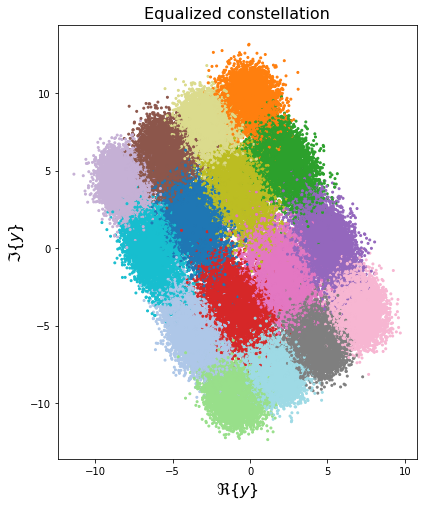

In [169]:
# Evaluate
model_jeq.eval()
model_jdemap.eval()

t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, 100000, seq_length)

f_eq = model_jeq(y).cpu().detach().numpy()
r_ch = y.cpu().detach().numpy()
t_sym = t.cpu().detach().numpy()

plt.figure(figsize=(8,8))

plt.scatter(f_eq[:,0], f_eq[:,1], c=t_sym, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{y\}$',fontsize=16)
plt.ylabel(r'$\Im\{y\}$',fontsize=16)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.2, 1.2))
plt.title('Equalized constellation',fontsize=16)


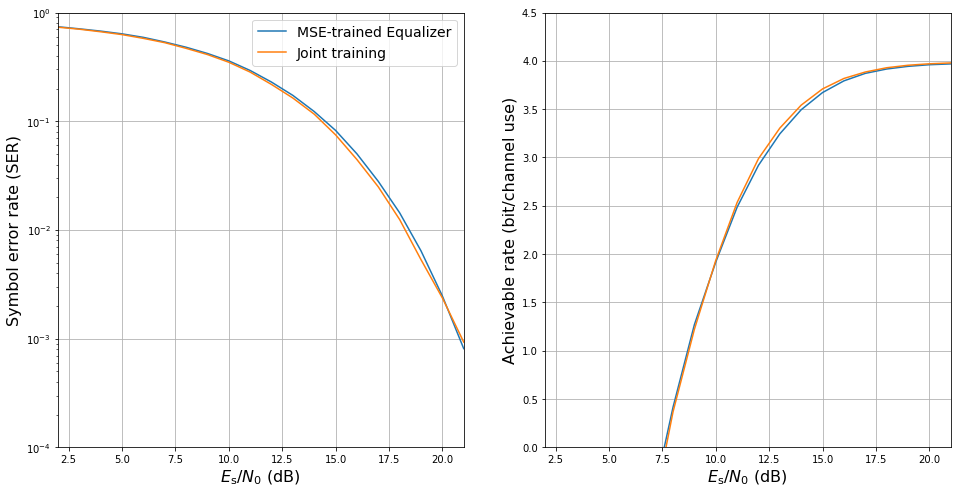

In [171]:
# Evaluate
model_jeq.eval()
model_jdemap.eval()

# compute SER and mutual information over a range of EsN0

SER_joint = np.zeros(len(esno_range_eval))
MI_joint = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = softmax(model_jdemap( model_jeq(y) ))
    
    SER_joint[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_joint[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.semilogy(esno_range_eval, SER_joint)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')
plt.legend(['MSE-trained Equalizer','Joint training', 'Joint training (Gaussian demapper)'], fontsize=14)

plt.subplot(122)
plt.plot(esno_range, MI_separate)
plt.plot(esno_range, MI_joint)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Achievable rate (bit/channel use)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')


---
### Joint training of neural network-based equalizer and standard Gaussian demapper

Now, we replace the neural-network based demapper by a standard Gaussian demapper, which computes 
$$
Q(t_i | y_i) \propto \exp\left(-\frac{\Vert y_i - t_i\Vert^2}{2\sigma^2}\right)
$$
where $\sigma^2$ is a trainable parameter.

This trains a nonlinear equalizer that can be used in a standard communication system, as it is widely employed.

In [172]:
class Gaussian_Demapper(nn.Module):
    def __init__(self, constellation):
        super(Gaussian_Demapper, self).__init__()
        
        self.sigma_square = nn.Parameter(torch.tensor(.1), requires_grad=True)
        
        self.register_buffer('constellation_real', torch.from_numpy(np.real(constellation)) )
        self.register_buffer('constellation_imag', torch.from_numpy(np.imag(constellation)) )                

    def forward(self, x):
        x_real = torch.transpose( (x[:,0]).repeat((len(self.constellation_real), 1)), 0,1)
        x_imag = torch.transpose( (x[:,1]).repeat((len(self.constellation_real), 1)), 0,1)
        
        # calculate Euclidean distance and Gaussian function
        out = (torch.square(x_real - self.constellation_real) + torch.square(x_imag - self.constellation_imag))
        out = torch.exp(-out / 2.0 / self.sigma_square)

        # normalize       
        out = out / torch.unsqueeze(torch.sum(out, axis=1), 1)
       
        return out

Carry out the training. Note that the Gaussian demapper already computes probabilities, so here we use it together with the NLLLoss loss function, which accepts log-probabilities, so we need to take care of taking an extra logarithm.

Note that we could also output directly log probabilities, but for the sake of simplicity, we decided to keep the demapper "standard" and modify the loss function.

In [173]:
# Joint training with Gaussian demapper
model_jgeq = Equalizer_Network(seq_length*2, 50, 20)
model_jgeq.to(device)

model_jgdemap = Gaussian_Demapper(constellations[con])
model_jgdemap.to(device)

optimizer_joint_Gaussian = optim.Adam( list(model_jgeq.parameters()) + list(model_jgdemap.parameters()) )

num_epochs = 100
batches_per_epoch = 500

loss_fn_jg = nn.NLLLoss()

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    
    for step in range(batches_per_epoch):
        
        _, toh, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, batch_size_per_epoch[epoch], seq_length)
        
        # Apply equalizer
        yeq = model_jgeq(y)
        
        # Apply Gaussian demapper
        outputs = model_jgdemap(yeq)
        
        # compute loss        
        loss = loss_fn(torch.log(outputs+0.000000001), toh)
        
         # compute gradients
        loss.backward()
        
        optimizer_joint_Gaussian.step()
                              
        # reset gradients
        optimizer_joint_Gaussian.zero_grad()
        
    if epoch % 10 == 0:
        print('Epoch %d: Loss %1.23f' % (epoch, loss.cpu().detach().numpy()))

Epoch 0: Loss 0.25325339501079213722079
Epoch 10: Loss 0.20846967339730609891646
Epoch 20: Loss 0.19829172888419352438483
Epoch 30: Loss 0.22435094246658968120123
Epoch 40: Loss 0.23049721449215390678411
Epoch 50: Loss 0.22434319481283412911488
Epoch 60: Loss 0.20481746622316238104489
Epoch 70: Loss 0.20203624415158533134118
Epoch 80: Loss 0.20181210604119945162260
Epoch 90: Loss 0.20570491244687202914143


Text(0.5, 1.0, 'Equalized constellation')

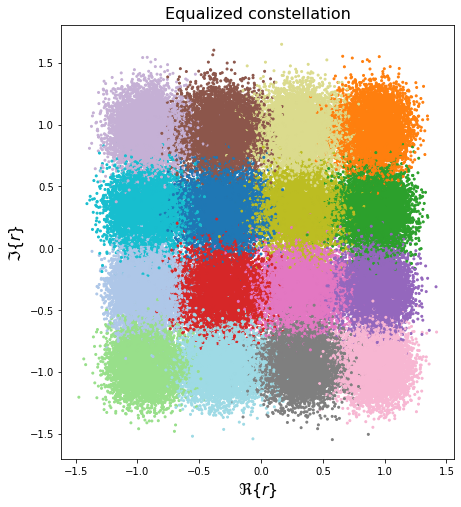

In [174]:
# Evaluate
model_jgeq.eval()
model_jgdemap.eval()

t, _, x, y = prepare_minibatch(constellations[con], h_ch, EsN0_dB, 100000, seq_length)

f_eq = model_jgeq(y).cpu().detach().numpy()
r_ch = y.cpu().detach().numpy()
t_sym = t.cpu().detach().numpy()

plt.figure(figsize=(8,8))

plt.scatter(f_eq[:,0], f_eq[:,1], c=t_sym, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.2, 1.2))
plt.title('Equalized constellation',fontsize=16)


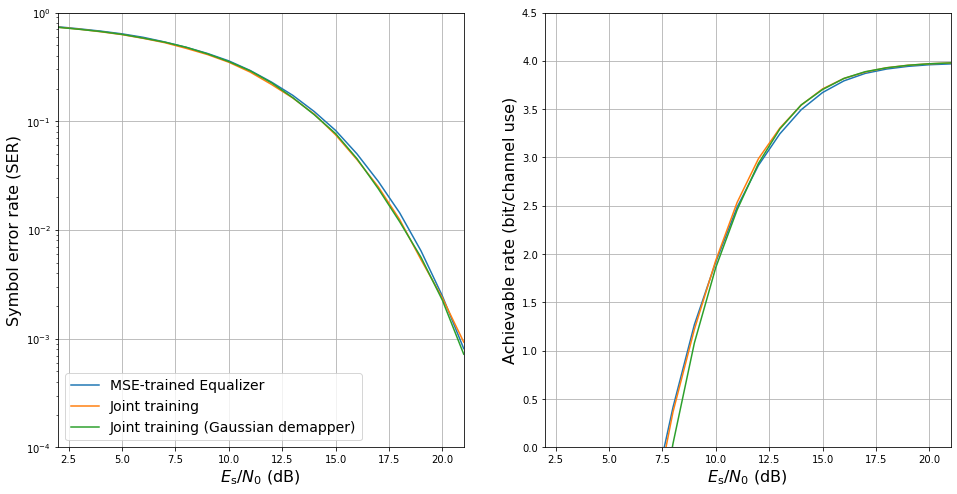

In [175]:
# Evaluate
model_jgeq.eval()
model_jgdemap.eval()

# compute SER and mutual information over a range of EsN0

SER_joint_Gaussian = np.zeros(len(esno_range_eval))
MI_joint_Gaussian = np.zeros(len(esno_range_eval))

for idx,esno in enumerate(esno_range_eval):
    t, _, x, y = prepare_minibatch(constellations[con], h_ch, esno, 100000, seq_length)

    output = model_jgdemap( model_jgeq(y) )   # outputs probabilities
    
    SER_joint_Gaussian[idx] = SER(output.detach().cpu().numpy(), t.detach().cpu().numpy())

    # compute MI
    tmp = output.detach().cpu().numpy()
    MI_joint_Gaussian[idx] = np.log2(len(constellations[con])) - np.mean(-np.log2(tmp[np.arange(tmp.shape[0]),t.detach().long().cpu().numpy()]))
    

   
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.semilogy(esno_range_eval, SER_separate)
plt.semilogy(esno_range_eval, SER_joint)
plt.semilogy(esno_range_eval, SER_joint_Gaussian)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Symbol error rate (SER)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((1e-4, 1))
plt.grid(which='major')
plt.legend(['MSE-trained Equalizer','Joint training', 'Joint training (Gaussian demapper)'], fontsize=14)
#plt.title('Equalized constellation',fontsize=16)

plt.subplot(122)
plt.plot(esno_range, MI_separate)
plt.plot(esno_range, MI_joint)
plt.plot(esno_range, MI_joint_Gaussian)
plt.xlabel(r'$E_{\mathrm{s}}/N_0$ (dB)',fontsize=16)
plt.ylabel('Achievable rate (bit/channel use)',fontsize=16)
plt.xlim((min(esno_range_eval), max(esno_range_eval)))
plt.ylim((0, 4.5))
plt.grid(which='major')
#plt.title('Equalized constellation',fontsize=16)
